## Chatbot (Natural Language Processing)

Introduction -

A chatbot is a computer program that engages in a conversation. Chatbots are being used to provide customer service in companies. Advances in technology is making chatbots smarter. In this project we aim to implement a Retrieval Based Chatbot.

There are 2 types of chatbots:
- Generative models
- Retreival based models

<i>Generative models</i> are implemented to predict a response based on a given input. This is achieved by modifying Machine Translation techniques. Instead of translating input from one language to another, we predict an output based on the given input.
    
<i>Retrieval models</i> use pre-defined repository of responses. Based on the input these responses are looked up based on some kind of methodology. These can be either a simple dictionary lookup or incorporating machine learning classifiers to pick the suitable response.

Domains of implementation -

- Open Domain: An open domain scenario involves the conversation to be continued with no restrictions on what the context of the conversation is. This makes it harder to recognise keywords and ensure the underlying meaning of the conversation is understood and also jump from one context to another. Data gathering plays an important role and lots of data will be required. sophisticated chatbots like Google Smart Reply use such open domain models.

- Close Domain: Closed domain involves contexts that exists within the domain chosen. The conversation context will not switch to a context that is outside the domain. Retrieval based models utilize closed domain data to implement techniques to predict the suitable replies.

In this project we will be implementing a Retrieval Based Model in closed domain. The reason for this choice is that Generative models require large amounts of data and are very hard to optimize. They also have the tendency to provide inconsistent replies based on the context of the conversation. 


### Dataset -

The dataset used is the Ubuntu Dialog Corpus. It consists of almost 1 million multi-turn dialogues, with a total of over 7 million utterances and 100 million words. The dataset was populated from chat logs from the Ubuntu IRC channels.


- Training data:
Training data contains 1,000,000 entries of which half are positive(Label =1)  and other half negative(label = 0). The data contains <i> Context </i>, <i>Utterances</i> fields. The context denotes the conversation that has occured upto this point and the utterance is the response to it. A positive label indicates that the utterance was relevant response to the context and a negative label indicates that the utterance was not relevant.
    
- Testing data:
The test data consists of a context(similar to that in training data), a ground truth utterance and 9 distractors. These 9 distractors are responses picked randomly from within the corpus.







## Preliminary Observations:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [5]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
y_test = np.zeros(len(test))

In [6]:
train.describe()

,Label
count,1000000.000000
mean,0.499873
std,0.500000
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Plotting the histogram based on the distribution of Label attribute in the dataset.

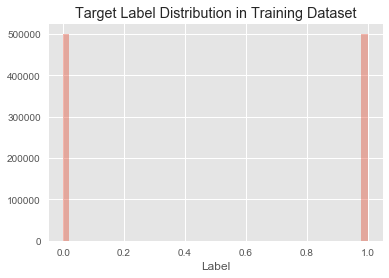

In [7]:
#train.Label.hist()
#plt.title("Target Label Distribution in Training Dataset")

sns.distplot(train.Label, hist = True, kde = False)
plt.title("Target Label Distribution in Training Dataset")


In [8]:
train.head()

,Context,Utterance,Label
0,i think we could import the old comment via rs...,basic each xfree86 upload will not forc user t...,1
1,i 'm not suggest all - onli the one you modifi...,sorri __eou__ i think it be ubuntu relat . __e...,0
2,afternoon all __eou__ not entir relat to warti...,"yep . __eou__ oh , okay . i wonder what happen...",0
3,interest __eou__ grub-instal work with / be ex...,that the one __eou__,1
4,and becaus python give mark a woodi __eou__ __...,( i think someon be go to make a joke about .a...,1


Plotting the distribution of lengths of context and utterances of every entry in the training data.

In [9]:
train_data_context = train.Context.str
train_data_context_lengths = train_data_context.split(" ").apply(len)

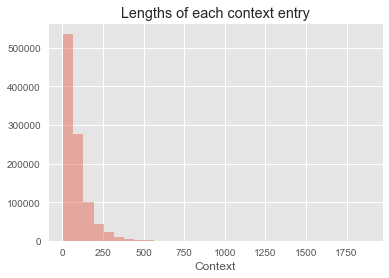

In [10]:
plt.title("Lengths of each context entry")
sns.distplot(train_data_context_lengths, bins = 30, kde = False)

In [12]:
train_data_utterance = train.Utterance.str
train_data_utterance_lengths = train_data_utterance.split(" ").apply(len)

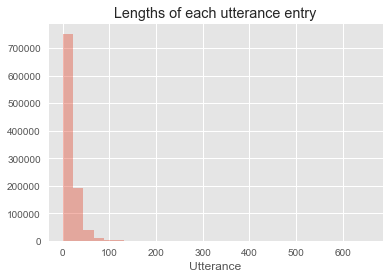

In [13]:
plt.title("Lengths of each utterance entry")
sns.distplot(train_data_utterance_lengths, bins = 30, kde = False)

From the above graphs we can observe that the lengths of contexts are more in comparison to the lengths of utterances/responses.

In [14]:
test.head()

,Context,Ground Truth Utterance,Distractor_0,Distractor_1,Distractor_2,Distractor_3,Distractor_4,Distractor_5,Distractor_6,Distractor_7,Distractor_8
0,anyon know whi my stock oneir export env var u...,nice thank ! __eou__,"wrong channel for it , but check efnet.org , u...","everi time the kernel chang , you will lose vi...",ok __eou__,! nomodeset > acer __eou__ i 'm assum it be a ...,http : //www.ubuntu.com/project/about-ubuntu/d...,thx __eou__ unfortun the program be n't instal...,how can i check ? by do a recoveri for test ? ...,my humbl apolog __eou__,# ubuntu-offtop __eou__
1,i set up my hd such that i have to type a pass...,"so you dont know , ok , anyon els ? __eou__ yo...","nmap be nice , but it be n't what i be look fo...",ok __eou__,cdrom work fine on window . __eou__ i dont thi...,"ah yes , i have read return as rerun __eou__",hm ? __eou__,"not the case , lts be everi other .04 releas ....",pretti much __eou__,i use the one i download from amd __eou__,"ffmpeg be part of the packag , quixotedon , at..."
2,im tri to use ubuntu on my macbook pro retina ...,just wonder how it run __eou__,"yes , that 's what i do , export it to a `` id...",noth - i be talk about the question of myhero ...,that should fix the font be too larg __eou__,"okay , so hcitool echo back hci0 < mac address...",i get to the menu with option such as tri ubun...,whi do u need analyz __eou__ it be a toy __eou...,cntrl-c may stop the command but it doe n't fi...,"if you re onli go to run ubuntu , just get a n...",the one which be not pick up at the moment be ...
3,no suggest ? __eou__ link ? __eou__ how can i ...,you cant load anyth via usb or cd when luk be ...,-p sorri ... __eou__ nmap -p22 __eou__ it doe ...,i guess so i ca n't even launch it . __eou__,note __eou__,rxvt-unicod be one __eou__,i tar all of ~ __eou__,i tar all of ~ __eou__,"i do n't realli know if i can help , but i be ...","that work just fine , thank ! __eou__",thank you __eou__
4,i just ad a second usb printer but not sure wh...,i be set it up under the printer configur __eo...,i 'd say the most common venu would be via lau...,"the old hardi man page , http : //manpages.ubu...",i ll give a tri __eou__,"by the way , the url you post for davf be from...",http : //ubuntuforums.org/showthread.php ? t=1...,"so i load up putti gui , then what do i do ? _...","you should read error messag , it say be you r...",wait the colleg semest to close just to make s...,i be call myself a jerk . all i know be that y...


In [15]:
test.describe()

,Context,Ground Truth Utterance,Distractor_0,Distractor_1,Distractor_2,Distractor_3,Distractor_4,Distractor_5,Distractor_6,Distractor_7,Distractor_8
count,18920,18920,18920,18920,18920,18920,18920,18920,18920,18920,18920
unique,18920,17914,13982,13902,14077,14041,14101,14072,13969,13975,14123
top,hi ! i just get a messag `` receiv unknown ctc...,thank __eou__,thank __eou__,thank __eou__,thank __eou__,thank __eou__,thank __eou__,thank __eou__,thank __eou__,thank __eou__,thank __eou__
freq,1,186,176,186,194,195,167,197,190,188,201


## Baseline Model Evaluation/Experimentation:

To check how models perform we evaluate using the recall@k approach. In this method we let the model choose k best responses out of the 10 possible responses present in the test data. We apply recall@k to two models,

- Simple random predictor: In this model we go with a simple approach where we pick the k best responses randomly.
- TFIDF predictor: Where we consider Term Frequency and Inverse Document Frequency to find the cosine similarity between the context and the utterances and choose the k most similar responses. These responses will be evaluated using recall@k.

### Recall at k:

Explanation - The test data contains a context and 10 possible utterances as seen before. To evaluate using recall@k we predict k responses, sort them and compare against our actual test output(actual utterance). If the actual utterance is present in the k responses then we consider a correct prediction to have been made.

This boils down to the fact that recall@1 will give a 10% score, recall@2 will give 20% and so on. In the function above, y is the index of the possible predictions made, say, [7, 6, 8, 1, 2, 3] and y_test contains the index of the right utterance i.e 0 in this case.

In [16]:
def recallAtK(y, y_test, k=1):
    input_examples_count = float(len(y)) #count of all context column entries from the training data
    total_number_correct = 0 #keep track of correct predictions
    for x, target in zip(y, y_test):
        if target in x[:k]: #recall@k pick range till kth entry
            total_number_correct += 1 #increment if prediction is present
    return total_number_correct/input_examples_count # return calculated recall

Simple random predictor -

In [17]:
#testing accuracy by making random predictions
y_random = []
for x in range(len(test)):
    y_random.append(np.random.choice(len(test.iloc[x,1:].values), 10, replace=False))


In [18]:
k_s = [1,2,4,6,8,10]
for n in k_s:
    print("Recall @ ",n,"=", recallAtK(y_random,y_test, n) )

Recall @  1 = 0.10280126849894292
Recall @  2 = 0.20174418604651162
Recall @  4 = 0.3980972515856237
Recall @  6 = 0.5971987315010571
Recall @  8 = 0.795507399577167
Recall @  10 = 1.0


TFIDF method -

TFIDF denotes the importance of a word in a document. Term Frequency is simply the frequency of a word in a given context. Inverse Document Frequency signifies the rarity of appearence of a word occuring somewhere else. 

tfidf(w, d, D) = f(w, d)× log N / |{d ∈ D : w ∈ d}|

f(w,d) - term frequency
log N / |{d ∈ D : w ∈ d}| - Inverse document frequency i.e total number of documents / total number of documents that the word occurs in

w - word
d - document
D - all documents

In our case, we calculate the tfidf vectors based on the context in the test data and the corresponding utterances. We the select the response based on the cosine similarity score of the context and each of the 10 responses. For recall@k the top k responses out of 10 responses is returned.

In [21]:
#TFIDF method

vectorizer = TfidfVectorizer()
vectorizer.fit(np.append(train.Context.values,train.Utterance.values))

def predict(context, utterances):
 # Convert context and utterances into tfidf vector
    
    vector_context = vectorizer.transform([context])
    
    vector_doc = vectorizer.transform(utterances)
    
    # The dot product measures the cosine similarity of the resulting vectors
    result = np.dot(vector_doc, vector_context.T).todense()
    
    result = np.asarray(result).flatten()
    
    # Sort by top results and return the indices in descending order
    return np.argsort(result, axis=0)[::-1]

In [22]:
t = []
for i in range(len(test)):
    t.append(predict(test.Context[i], test.iloc[i,1:]))

In [23]:
k_s = [1,2,4,6,8,10]
for n in k_s:
    print("Recall @ ",n,"=", recallAtK(t,y_test, n) ) # because first entry is the correct utterance and remaining 9 are distractors 

Recall @  1 = 0.4950317124735729
Recall @  2 = 0.5968816067653276
Recall @  4 = 0.7137949260042283
Recall @  6 = 0.8135306553911205
Recall @  8 = 0.9094080338266385
Recall @  10 = 1.0


From the above we can observe that there is significant gain in the scores obtained. However based on the research done by Lowe et al. RNN provided significantly better recall rates as compared to TF-IDF and Random predictor. But however, according to them LSTM modification to the RNN provided better scores as compared to standalone RNN. Hence we decided to proceed with implementation of RNN and LSTM.